In [36]:
import torch.nn  as nn
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
import torchvision.utils
import matplotlib.pyplot as plt
import random
from torchvision.transforms import transforms
from torch.utils.data import random_split
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
import torch

In [37]:
dataset = CIFAR10(root = "data/cifar10/" , download = True , transform= ToTensor())

Files already downloaded and verified


In [38]:
image,label = dataset[4]

In [39]:
image.shape , label

(torch.Size([3, 32, 32]), 1)

In [40]:
classes = dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


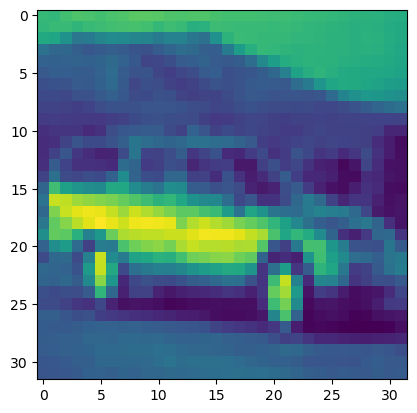

In [41]:
plt.imshow(image[0])

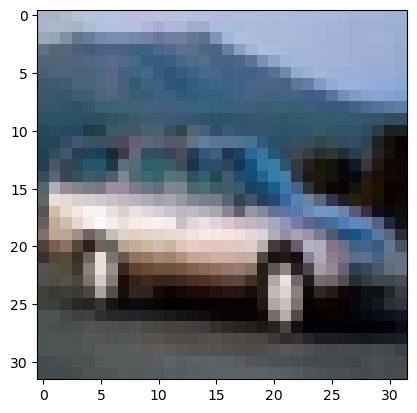

In [42]:
plt.imshow(image.permute(1,2,0))

In [43]:
validation_set_len = 10000
total_dataset_len = len(dataset)
train_dataset_len = total_dataset_len - validation_set_len
print(train_dataset_len)

40000


In [44]:
train_dataset , validation_dataset = random_split(dataset , [train_dataset_len,validation_set_len])

In [45]:
print(train_dataset, validation_dataset)

<torch.utils.data.dataset.Subset object at 0x000001F339373590> <torch.utils.data.dataset.Subset object at 0x000001F3393729F0>


In [46]:
batch_size = 128

In [47]:
train_dataloader = DataLoader(dataset= train_dataset, batch_size = batch_size , shuffle= True , num_workers=4)
validation_dataloader = DataLoader(dataset= validation_dataset , batch_size= batch_size , shuffle= False , num_workers= 4)

torch.Size([3, 274, 546])
torch.Size([274, 546, 3])


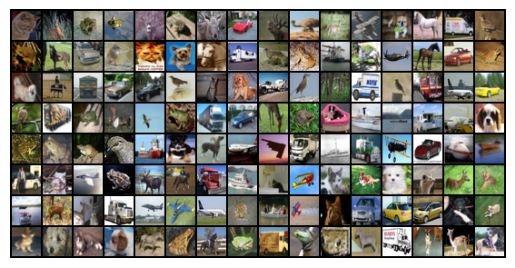

In [48]:
for images , labels in train_dataloader :
    grid = torchvision.utils.make_grid(images,nrow = 16)
    print(grid.shape)
    grid = grid.permute(1,2,0)
    print(grid.shape) 
    plt.axis('off')
    plt.imshow(grid)
    break

In [49]:
for images , labels in train_dataloader :
    inputs = images.reshape(-1,32*32*3)
    print(inputs.shape) #[-1,3072]
    break
input_size = inputs.shape[-1]  #3072
hidden_size = 32
     

torch.Size([128, 3072])


In [50]:
class ClassficationModel(nn.Module):
    def __init__(self , input_size , out_size):
        super().__init__()
        hidden_size1 = 128
        hidden_size2 = 64
        self.linear1 = nn.Linear(input_size,hidden_size1)
        self.linear2 = nn.Linear(hidden_size1,hidden_size2)
        self.linear3 = nn.Linear(hidden_size2,out_size)

    def forward(self , xb):
        xb = xb.reshape(xb.size(0),-1)
        #print(xb.shape)
        out = self.linear1(xb);
        out = F.relu(out)
        out = self.linear2(out);
        out = F.relu(out)
        out = self.linear3(out);
        return out

    def training_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
        return loss

    def validation_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
       # print(output.shape)
       # print(labels)
        
        acc = self.accuracy(output , labels)
        return {'val_loss' : loss , "val_acc" : acc}
         
    def validation_epoch_end(self , output):
        batch_losses = [x['val_loss'] for x in output]
        batch_accuracy = [x['val_acc'] for x in output]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'epoch_val_loss' : epoch_loss.item() , 'epoch_val_accuracy' : epoch_accuracy.item()}

    def epoch_end(self , epoch , result):
        print('Epoch ' + str(epoch) +  ' Validation Loss : ' + str(result['epoch_val_loss']) + ' Validation Accuracy' + str(result['epoch_val_accuracy']) + "\n")

    def accuracy(self,outputs , label):
        probabilities,prediction = torch.max(outputs,dim=1)
        return torch.sum(label == prediction) / label.numel()   



In [51]:
model = ClassficationModel(input_size = 32*32 * 3,out_size=len(classes))

In [52]:
for param in model.parameters() :
    print(param.shape) 

torch.Size([128, 3072])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [53]:
for batch in train_dataloader : 
    loss = model.training_step(batch)
    print('Loss' , loss.item())
    break
    

Loss 2.3053600788116455


<h2>Using GPU</h2>

In [54]:
isCudaAvailable = torch.cuda.is_available()
print(isCudaAvailable)

True


In [55]:
def get_degault_device():
    device_name = ''
    if torch.cuda.is_available() :
        device_name = 'cuda'
    else: 
        device_name = 'cpu' 
        
    return torch.device(device_name)
        

In [56]:
print(get_degault_device())

cuda


In [57]:
def to_device(data,device):
    if isinstance(data,(list,tuple)) :
        return[to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

In [58]:
def to_default_device(data):
    return to_device(data,get_degault_device())

In [59]:
for images,labels in train_dataloader : 
    print(images.shape)
    print(images.device)
    images = to_default_device(images)
    print(images.shape)
    print(images.device)
    break
    

torch.Size([128, 3, 32, 32])
cpu
torch.Size([128, 3, 32, 32])
cuda:0


In [60]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for item in self.dl :
            yield to_device(item,self.device)
               

    def to_device(data,device):
        if isinstance(data,(list,tuple)) :
            return[to_device(x,device) for x in data]
        return data.to(device,non_blocking = True)

    def __len__(self):
        return len(self.dl)



In [61]:
train_dataloader = DeviceDataLoader(dl=train_dataloader,device=get_degault_device())
validation_dataloader = DeviceDataLoader(dl=validation_dataloader,device=get_degault_device())

In [62]:
for batch in train_dataloader:
    print(batch[0].device)
    print(batch[1])
    break

cuda:0
tensor([1, 3, 4, 2, 3, 2, 1, 5, 0, 7, 7, 2, 6, 4, 3, 5, 2, 8, 2, 6, 7, 9, 3, 8,
        5, 4, 6, 6, 7, 4, 2, 9, 3, 5, 0, 2, 5, 1, 3, 8, 6, 4, 6, 4, 2, 9, 2, 2,
        0, 1, 6, 8, 0, 4, 7, 4, 5, 2, 2, 7, 2, 8, 0, 7, 8, 7, 1, 0, 3, 4, 8, 1,
        4, 8, 7, 8, 7, 2, 9, 5, 7, 3, 0, 4, 1, 0, 6, 1, 5, 7, 4, 3, 5, 4, 7, 7,
        8, 2, 3, 3, 2, 0, 9, 7, 4, 9, 8, 8, 7, 2, 3, 7, 7, 3, 4, 7, 1, 9, 9, 4,
        1, 3, 2, 3, 0, 5, 7, 4], device='cuda:0')


In [63]:
def fit(epochs , lr , model , train_loader , val_loader , opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        
        epoch_val_result = []
        for val_batch in val_loader:
            val_result = model.validation_step(val_batch)
            epoch_val_result.append(val_result)
               
        epoch_end_val_result = model.validation_epoch_end(epoch_val_result)
        model.epoch_end(epoch,epoch_end_val_result)
        history.append(epoch_end_val_result)
        
    return history

In [64]:
model = to_default_device(model)
print(next(model.parameters()).is_cuda)

True


In [ ]:
model.load_state_dict(torch.load("mnist-multilayer_cifar10.pth"))

In [65]:
history = fit(50, 0.001,model,train_loader=train_dataloader,val_loader= validation_dataloader)
torch.save(model.state_dict(),"mnist-multilayer_cifar10.pth")

Epoch 0 Validation Loss : 2.2974019050598145 Validation Accuracy0.1152096539735794

Epoch 1 Validation Loss : 2.291147470474243 Validation Accuracy0.14210839569568634

Epoch 2 Validation Loss : 2.2843239307403564 Validation Accuracy0.1734572798013687

Epoch 3 Validation Loss : 2.276604413986206 Validation Accuracy0.19541139900684357

Epoch 4 Validation Loss : 2.2675437927246094 Validation Accuracy0.20579509437084198

Epoch 5 Validation Loss : 2.2571771144866943 Validation Accuracy0.21133308112621307

Epoch 6 Validation Loss : 2.2452454566955566 Validation Accuracy0.21331092715263367

Epoch 7 Validation Loss : 2.2314491271972656 Validation Accuracy0.21687105298042297

Epoch 8 Validation Loss : 2.215749740600586 Validation Accuracy0.22270570695400238

Epoch 9 Validation Loss : 2.197934865951538 Validation Accuracy0.22923259437084198

Epoch 10 Validation Loss : 2.1787314414978027 Validation Accuracy0.23714399337768555

Epoch 11 Validation Loss : 2.1587204933166504 Validation Accuracy0.245

In [ ]:
for each_epoch_result in history:
    print(each_epoch_result)
accuracies = [each_epoch_result['epoch_val_accuracy']for each_epoch_result in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')


In [ ]:
test_dataset = CIFAR10(root = "data/cifar10/" , train = False , transform= transforms.ToTensor())

In [ ]:
def predict_image(img , model):
    img = to_default_device(img)
    image_with_batch_dimention = img.unsqueeze(0) #adds another dimention as the model as the batch size as the first dimention.
    result = model(image_with_batch_dimention)
    max_value , index = torch.max(result,dim = 1)
    return index.item()
    

In [ ]:
img,label=test_dataset[random.randint(0,len(test_dataset))]
predict_image(img,model)
print("Label is " + str(label) + " Prediction is " + str(predict_image(img,model)))
plt.imshow(img[0])